In [9]:
from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
import numpy as np
import tensorflow as tf
# from tensorflow import keras
# import matplotlib.pyplot as plt
from model_archi import *
import pandas as pd


# RDLogger.DisableLog("rdApp.*")

2023-09-25 16:25:48.202664: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-09-25 16:25:48.202683: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-09-25 16:25:48.202686: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-09-25 16:25:48.203084: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-25 16:25:48.203206: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
new_model = GraphWGAN(generator, discriminator, discriminator_steps=1)

new_model.compile(
    optimizer_generator=keras.optimizers.Adam(5e-4),
    optimizer_discriminator=keras.optimizers.Adam(5e-4),
)
new_model.built = True

In [12]:
savedModel = new_model.load_weights('model_weights.h5')

2/2 [==============================] - 0s 20ms/step


2023-09-25 16:25:54.989401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


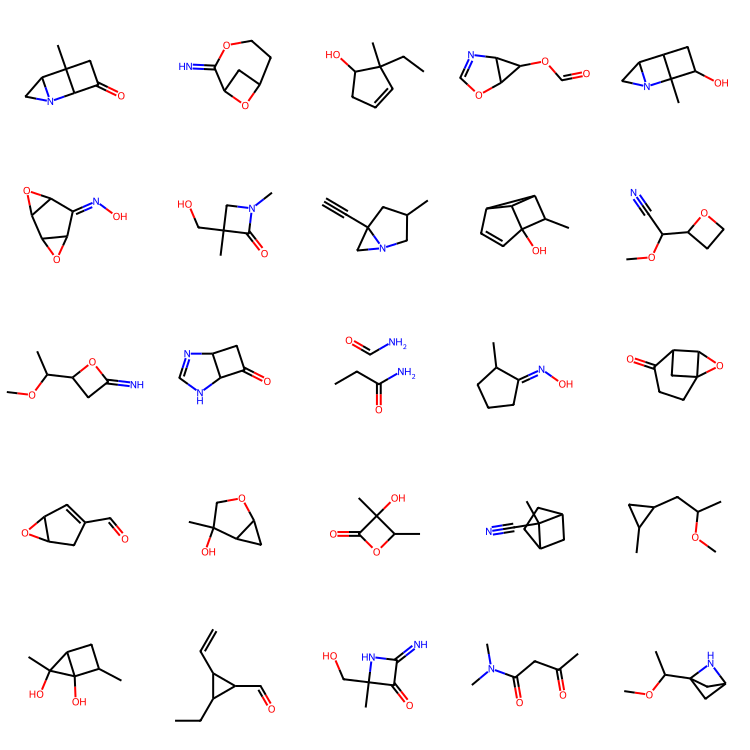

In [13]:
def sample(generator, batch_size):
    z = tf.random.normal((batch_size, LATENT_DIM))
    graph = generator.predict(z)
    # obtain one-hot encoded adjacency tensor
    adjacency = tf.argmax(graph[0], axis=1)
    adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
    # Remove potential self-loops from adjacency
    adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
    # obtain one-hot encoded feature tensor
    features = tf.argmax(graph[1], axis=2)
    features = tf.one_hot(features, depth=ATOM_DIM, axis=2)
    return [
        graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
        for i in range(batch_size)
    ]


molecules = sample(new_model.generator, batch_size=48)

MolsToGridImage(
    [m for m in molecules if m is not None][:25], molsPerRow=5, subImgSize=(150, 150)
)

In [14]:
csv_path = tf.keras.utils.get_file(
    "qm9.csv", "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/qm9.csv"
)

data = []
with open(csv_path, "r") as f:
    for line in f.readlines()[1:]:
        data.append(line.split(",")[1])

# Validity

In [15]:
def validity(generator, batch_size):
    z = tf.random.normal((batch_size, LATENT_DIM))
    graph = generator.predict(z)
    # obtain one-hot encoded adjacency tensor
    adjacency = tf.argmax(graph[0], axis=1)
    adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
    # Remove potential self-loops from adjacency
    adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
    # obtain one-hot encoded feature tensor
    features = tf.argmax(graph[1], axis=2)
    features = tf.one_hot(features, depth=ATOM_DIM, axis=2)
    n_valid = 0
    for i in range(batch_size):
        molecule = graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
        if molecule != None:
            n_valid += 1
    
    return n_valid/batch_size

print(validity(new_model.generator, batch_size=1024))

32/32 [==============================] - 0s 2ms/step
0.7939453125


In [16]:
def smiles_from_molecules(mol):
    smiles = Chem.MolToSmiles(mol)
    return smiles

In [17]:
def valid_mols(generator, batch_size):
    z = tf.random.normal((batch_size, LATENT_DIM))
    graph = generator.predict(z)
    # obtain one-hot encoded adjacency tensor
    adjacency = tf.argmax(graph[0], axis=1)
    adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
    # Remove potential self-loops from adjacency
    adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
    # obtain one-hot encoded feature tensor
    features = tf.argmax(graph[1], axis=2)
    features = tf.one_hot(features, depth=ATOM_DIM, axis=2)
    
    valid_molecules = []
    for i in range(batch_size):
        molecule = graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
        if molecule != None:
            valid_molecules.append(molecule)
    return valid_molecules

# Novelty

In [45]:
from joblib import Parallel, delayed

def check_novelty(dataset, gen_mol):
    novel = 1
    for molecule in dataset:
        if Chem.CanonSmiles(smiles_from_molecules(gen_mol)) == Chem.CanonSmiles(molecule):
            novel = 0
            break
    return novel

def novelty(generator, batch_size):
    molecules = valid_mols(generator, batch_size=batch_size)
    n_novelty = np.sum(Parallel(n_jobs=8)(delayed(check_novelty)(data, m) for m in molecules))
    return n_novelty/len(molecules)

print(novelty(new_model.generator, batch_size=1024))
        

32/32 [==============================] - 0s 2ms/step
0.33579335793357934


# Uniqueness

In [46]:
from collections import Counter

def uniqueness(generator, batch_size):
    mols = valid_mols(generator, batch_size=batch_size)
    count = Counter([Chem.CanonSmiles(smiles_from_molecules(m)) for m in mols])

    return sum([v for k, v in count.items() if v == 1])/len(count)

print(uniqueness(new_model.generator, batch_size=1024))

32/32 [==============================] - 0s 2ms/step
0.8425787106446777
